In [4]:
!pip install yfinance pandas


In [7]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=443a30e20ba882673b538bea5aedf463225ad8b1a358e5e8bb9f0449297abf77
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [8]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta

# Define the stock ticker and date range
ticker = "AAPL"
start_date = "2023-01-01"
end_date = "2024-01-01"

# Fetch historical data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Print a sample of the data
print(data.head())

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  123.904633   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.182617   
2023-01-05  127.129997  127.769997  124.760002  125.019997  123.855095   
2023-01-06  126.010002  130.289993  124.889999  129.619995  128.412231   
2023-01-09  130.470001  133.410004  129.889999  130.149994  128.937317   

               Volume  
Date                   
2023-01-03  112117500  
2023-01-04   89113600  
2023-01-05   80962700  
2023-01-06   87754700  
2023-01-09   70790800  


In [9]:

# Calculate technical indicators
# Moving Average (20-day Simple Moving Average)
data['SMA_20'] = ta.sma(data['Close'], length=20)

# Exponential Moving Average (20-day)
data['EMA_20'] = ta.ema(data['Close'], length=20)

# Relative Strength Index (RSI, 14-day)
data['RSI_14'] = ta.rsi(data['Close'], length=14)

# Bollinger Bands (20-day)
bbands = ta.bbands(data['Close'], length=20, std=2)
data = pd.concat([data, bbands], axis=1)

# Moving Average Convergence Divergence (MACD)
macd = ta.macd(data['Close'], fast=12, slow=26, signal=9)
data = pd.concat([data, macd], axis=1)

# Print a sample of the calculated indicators
print(data[['Close', 'SMA_20', 'EMA_20', 'RSI_14', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'MACD_12_26_9', 'MACDs_12_26_9']].tail())

# Save to a CSV file (optional)
data.to_csv('technical_indicators.csv')

                 Close      SMA_20      EMA_20     RSI_14  BBL_20_2.0  \
Date                                                                    
2023-12-22  193.600006  193.668501  193.330404  54.609714  187.993883   
2023-12-26  193.050003  193.831501  193.303699  53.026884  188.431228   
2023-12-27  193.149994  193.969001  193.289060  53.291939  188.789699   
2023-12-28  193.580002  194.179501  193.316769  54.481470  189.441568   
2023-12-29  192.529999  194.308501  193.241839  51.061838  189.909879   

            BBM_20_2.0  BBU_20_2.0  MACD_12_26_9  MACDs_12_26_9  
Date                                                             
2023-12-22  193.668501  199.343118      2.636317       3.236690  
2023-12-26  193.831501  199.231774      2.306308       3.050613  
2023-12-27  193.969001  199.148303      2.029448       2.846380  
2023-12-28  194.179501  198.917435      1.823710       2.641846  
2023-12-29  194.308501  198.707124      1.557975       2.425072  


In [11]:
import numpy as np
# Calculate a simple moving average as a signal (20-day)
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# Define a trading strategy (crossover strategy)
data['Signal'] = 0
data['Signal'][20:] = np.where(data['Close'][20:] > data['SMA_20'][20:], 1, -1)  # Buy above SMA, Sell below SMA
data['Position'] = data['Signal'].shift()  # Shift to represent the actual position

# Backtest Framework
initial_capital = 10000  # Initial capital in USD
position_size = 10  # Number of shares per trade

<ipython-input-11-fd9a8f6b566f>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Signal'][20:] = np.where(data['Close'][20:] > data['SMA_20'][20:], 1, -1)  # Buy above SMA, Sell below SMA
<ipython-input-11-fd9a8f6b566f>:7: SettingWithC

In [12]:
# Calculate daily portfolio value
data['Daily_Return'] = data['Close'].pct_change()
data['Portfolio_Return'] = data['Position'] * data['Daily_Return'] * position_size
data['Portfolio_Value'] = initial_capital * (1 + data['Portfolio_Return']).cumprod()


In [13]:
# Performance Metrics
total_return = data['Portfolio_Value'].iloc[-1] - initial_capital
cumulative_return = (data['Portfolio_Value'].iloc[-1] / initial_capital) - 1
annualized_return = (1 + cumulative_return) ** (252 / len(data)) - 1

# Calculate daily returns and standard deviation for Sharpe Ratio
mean_daily_return = data['Portfolio_Return'].mean()
std_daily_return = data['Portfolio_Return'].std()
sharpe_ratio = (mean_daily_return / std_daily_return) * np.sqrt(252)


Total Return: $3607.04
Cumulative Return: 36.07%
Annualized Return: 36.41%
Sharpe Ratio: 1.11
Maximum Drawdown: -81.78%


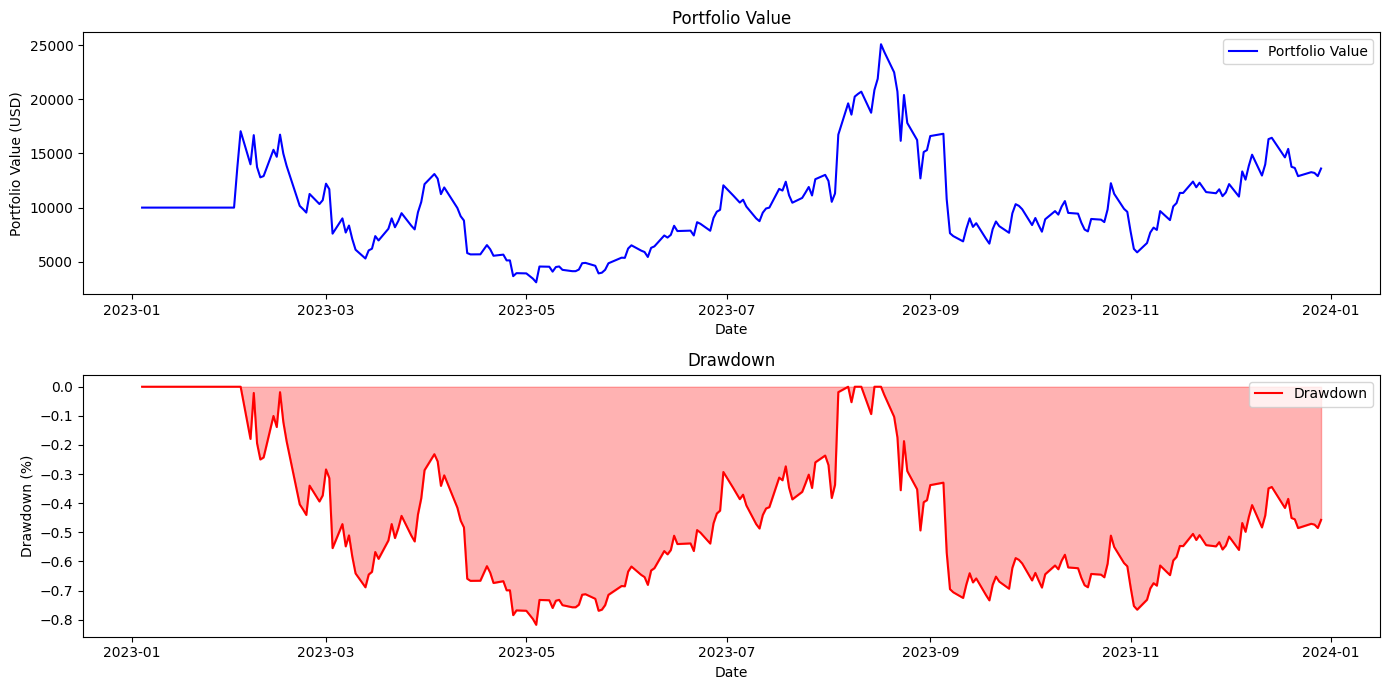

In [15]:
import matplotlib.pyplot as plt
# Maximum Drawdown
data['Peak_Value'] = data['Portfolio_Value'].cummax()
data['Drawdown'] = (data['Portfolio_Value'] - data['Peak_Value']) / data['Peak_Value']
max_drawdown = data['Drawdown'].min()

# Print performance metrics
print("Total Return: ${:.2f}".format(total_return))
print("Cumulative Return: {:.2%}".format(cumulative_return))
print("Annualized Return: {:.2%}".format(annualized_return))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
print("Maximum Drawdown: {:.2%}".format(max_drawdown))

# Plot portfolio value and drawdown
plt.figure(figsize=(14, 7))

# Portfolio Value
plt.subplot(2, 1, 1)
plt.plot(data['Portfolio_Value'], label='Portfolio Value', color='blue')
plt.title('Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()

# Drawdown
plt.subplot(2, 1, 2)
plt.plot(data['Drawdown'], label='Drawdown', color='red')
plt.fill_between(data.index, data['Drawdown'], 0, color='red', alpha=0.3)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()

plt.tight_layout()
plt.show()